<a href="https://colab.research.google.com/github/aayushis1203/dietcheck/blob/main/01_task1_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DietCheck – 01 Modeling Task 1 (Dietary Labels)

This notebook trains and evaluates models for **Task 1: automatic dietary labels** using
the dataset created in `00_data_collection_and_automatic_labels.ipynb`.

**Task 1 labels (multi-label):**

- `keto_compliant`
- `high_protein`
- `low_sodium`
- `low_fat`

Each product can satisfy **0 to 4** of these labels, so this is a **multi-label** problem.
Here we follow a simple but standard approach: we train **four independent binary
classifiers**, one per label. This makes evaluation and interpretation straightforward,
while still covering the multi-label setting.

**Research question (aligned with your plan):**

> Does ingredient text provide additional predictive signal beyond numeric nutrition
> facts for dietary labels?

To answer this, we compare three baseline model families:

1. **Text-only baseline**  
   - Features: ingredient list text  
   - Model: TF–IDF + Logistic Regression  

2. **Numeric-only baseline**  
   - Features: per-serving nutrition values  
   - Model: Standardized numeric features + Logistic Regression  

3. **Multimodal baseline**  
   - Features: ingredient text + numeric features  
   - Model: ColumnTransformer (text + numeric) + Logistic Regression  

For each family we use **Stratified 5-fold cross-validation** on the training set and
compute:

- ROC AUC and PR AUC (per label)  
- Brier score (probability calibration)  
- F1 / precision / recall for the positive class  
- Calibration (reliability) curves  
- ROC curves  

We also:

- Inspect **label balance** and **label co-occurrence**  
- Save **model checkpoints** (`joblib`) and **metrics/configuration** (`JSON`) for reuse  
- Perform a small **qualitative error analysis** for one label  


In [72]:
# ============================================================================
# Cell 2: Imports, plotting style, and global configuration
# ============================================================================

import os
import json
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

import joblib

warnings.filterwarnings("ignore")

# Plotting style: simple and publication-ready
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("➤ Libraries imported and plotting style configured.")


➤ Libraries imported and plotting style configured.


In [73]:
# ============================================================================
# Cell 3: Workspace setup and file paths
# ============================================================================

def find_repo_root(marker: str = ".git") -> Path:
    """
    Locate the repository root by searching upwards for a given marker directory.

    Parameters
    ----------
    marker : str
        Directory name that indicates the root of the repository, typically ".git".

    Returns
    -------
    Path
        Absolute path to the repository root. If the marker is not found,
        returns the current working directory.
    """
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    return current


REPO_ROOT = find_repo_root()
DATA_DIR = REPO_ROOT / "data"
RESULTS_DIR = REPO_ROOT / "results"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"➤ Repo root     : {REPO_ROOT}")
print(f"➤ Data directory: {DATA_DIR}")
print(f"➤ Results dir   : {RESULTS_DIR}")


➤ Repo root     : /content/dietcheck/dietcheck/dietcheck
➤ Data directory: /content/dietcheck/dietcheck/dietcheck/data
➤ Results dir   : /content/dietcheck/dietcheck/dietcheck/results


In [74]:
# ============================================================================
# Cell 4: Load dataset (train/test) and basic inspection
# ============================================================================

train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

if not train_path.exists():
    raise FileNotFoundError(
        f"train.csv not found at {train_path}. "
        "Make sure 00 notebook has been run."
    )

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path) if test_path.exists() else None

print("➤ Loaded datasets:")
print(f"   Train shape : {df_train.shape}")
if df_test is not None:
    print(f"   Test shape  : {df_test.shape}")
else:
    print("   Test shape  : None (test.csv not found; will rely on CV only)")

df_train.head()


➤ Loaded datasets:
   Train shape : (223, 28)
   Test shape  : (56, 28)


,product_id,name,brand,category,ingredients,serving_size_g,energy_100g,fat_100g,saturated_fat_100g,carbs_100g,...,carbs_per_serving,fiber_per_serving,sugars_per_serving,protein_per_serving,sodium_per_serving,net_carbs_per_serving,keto_compliant,high_protein,low_sodium,low_fat
0,20103644,Kokosmilch,Freshona,en:plant-based-foods-and-beverages,"91% coconut extract, water, guar gum stabilizer,",1400.0,194.0,20.50,16.8,1.40,...,19.60,8.4,12.60,11.20,280.0,11.20,0,1,0,0
1,6111184004129,Mayonnaise recette originale,Star,en:condiments,"Huile de soja, eau, vinaigre de table, jaune d...",100.0,592.0,65.21,9.8,0.22,...,0.22,0.0,0.05,1.12,700.0,0.22,1,0,0,0
2,8422174010029,Gazpacho Original,"Alvalle, PepsiCo",en:plant-based-foods-and-beverages,"Verdures fresques (94%) (tomàquet, pebrot verm...",100.0,42.0,2.40,0.4,3.50,...,3.50,1.2,3.30,0.90,248.0,2.30,1,0,0,1
3,6111128000163,Ain Saiss Eau Minerale Naturelle,Danone,en:beverages-and-beverages-preparations,"Calcium : 63,5\r\nMagnésium : 35,5\r\nNitratex...",33.0,0.0,0.00,0.0,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,1,0,1,1
4,50457243,Tomato Ketchup,Heinz,en:condiments,"Tomatoes, Spirit Vinegar, Sugar, Salt, Spice a...",15.0,102.0,0.10,0.0,23.20,...,3.48,0.0,3.42,0.18,108.0,3.48,1,0,1,1


## 1. Labels and Feature Definitions

We treat Task 1 as **four binary classification problems**:

- `keto_compliant`
- `high_protein`
- `low_sodium`
- `low_fat`

For features, we define:

- **Text column**:  
  - `name`+`ingredients`  

- **Numeric features (per serving)** – motivated by FDA-style macronutrient labels:  
  - `net_carbs_per_serving`  
  - `protein_per_serving`  
  - `sodium_per_serving`  
  - `fat_per_serving`  
  - `energy_per_serving`  
  - `fiber_per_serving`  
  - `sugars_per_serving`  

These numeric features directly reflect the quantities used in your automatic labeling
rules from notebook 00.


In [75]:
# ============================================================================
# Cell 5: Define label, text, and numeric features (name + ingredients)
# ============================================================================

# Multi-label targets for Task 1
LABEL_COLS = ["keto_compliant", "high_protein", "low_sodium", "low_fat"]

# --------------------------------------------------------------------------
# Build combined text feature: name + " | " + ingredients
# --------------------------------------------------------------------------
REQUIRED_TEXT_COLS = ["name", "ingredients"]
missing_text_cols = [c for c in REQUIRED_TEXT_COLS if c not in df_train.columns]
if missing_text_cols:
    raise ValueError(
        f"Missing required text columns in train.csv: {missing_text_cols}"
    )

def build_text_all(df: pd.DataFrame) -> pd.Series:
    """
    Combine product name and ingredients into a single text field.

    Format: 'Name | ingredients...'
    """
    name = df["name"].fillna("").astype(str)
    ing = df["ingredients"].fillna("").astype(str)

    text_all = (name.str.strip() + " | " + ing.str.strip()).str.strip()
    # Collapse excessive whitespace
    text_all = text_all.str.replace(r"\s+", " ", regex=True)
    return text_all

# Build for train
df_train["text_all"] = build_text_all(df_train)

# Build for test if available and has the columns
if df_test is not None:
    if all(c in df_test.columns for c in REQUIRED_TEXT_COLS):
        df_test["text_all"] = build_text_all(df_test)
    else:
        print(
            "➤ Warning: df_test is missing 'name' or 'ingredients'; "
            "text_all will not be available for test baselines."
        )

# Use the combined column as the only text feature
TEXT_COL = "text_all"

# --------------------------------------------------------------------------
# Numeric features (per serving) – same as before
# --------------------------------------------------------------------------
NUMERIC_FEATURES = [
    "net_carbs_per_serving",
    "protein_per_serving",
    "sodium_per_serving",
    "fat_per_serving",
    "energy_per_serving",
    "fiber_per_serving",
    "sugars_per_serving",
]

# Basic checks
missing_labels = [col for col in LABEL_COLS if col not in df_train.columns]
if missing_labels:
    raise ValueError(
        f"Missing expected label columns in train.csv: {missing_labels}"
    )

if TEXT_COL not in df_train.columns:
    raise ValueError(
        f"Expected text column '{TEXT_COL}' not found in train.csv."
    )

missing_numeric = [col for col in NUMERIC_FEATURES if col not in df_train.columns]
if missing_numeric:
    raise ValueError(
        f"Missing expected numeric feature columns: {missing_numeric}"
    )

# --------------------------------------------------------------------------
# Prepare feature views
# --------------------------------------------------------------------------
X_text = df_train[TEXT_COL].fillna("")
X_numeric = df_train[NUMERIC_FEATURES].fillna(0.0)
X_multimodal = df_train[[TEXT_COL] + NUMERIC_FEATURES].copy()  # DataFrame with both

y_labels = df_train[LABEL_COLS].astype(int)

print("⮕ Features and labels prepared (name + ingredients).")
print("➤  Text column     :", TEXT_COL)
print("➤  Numeric columns :", NUMERIC_FEATURES)
print("➤  Label columns   :", LABEL_COLS)


⮕ Features and labels prepared (name + ingredients).
➤  Text column     : text_all
➤  Numeric columns : ['net_carbs_per_serving', 'protein_per_serving', 'sodium_per_serving', 'fat_per_serving', 'energy_per_serving', 'fiber_per_serving', 'sugars_per_serving']
➤  Label columns   : ['keto_compliant', 'high_protein', 'low_sodium', 'low_fat']


## 2. Label Balance and Co-occurrence

Task 1 is **multi-label**: each product can satisfy zero or more of the four claims.
Before modeling, we inspect:

- How balanced each label is (how many positives)  
- How often labels co-occur (e.g., keto + high protein)

This helps interpret metrics later (e.g., PR AUC is more informative than accuracy
for rare labels).


⮕ Label balance (train):


,count,proportion
low_sodium,97,0.434978
high_protein,89,0.399103
low_fat,77,0.345291
keto_compliant,72,0.322870


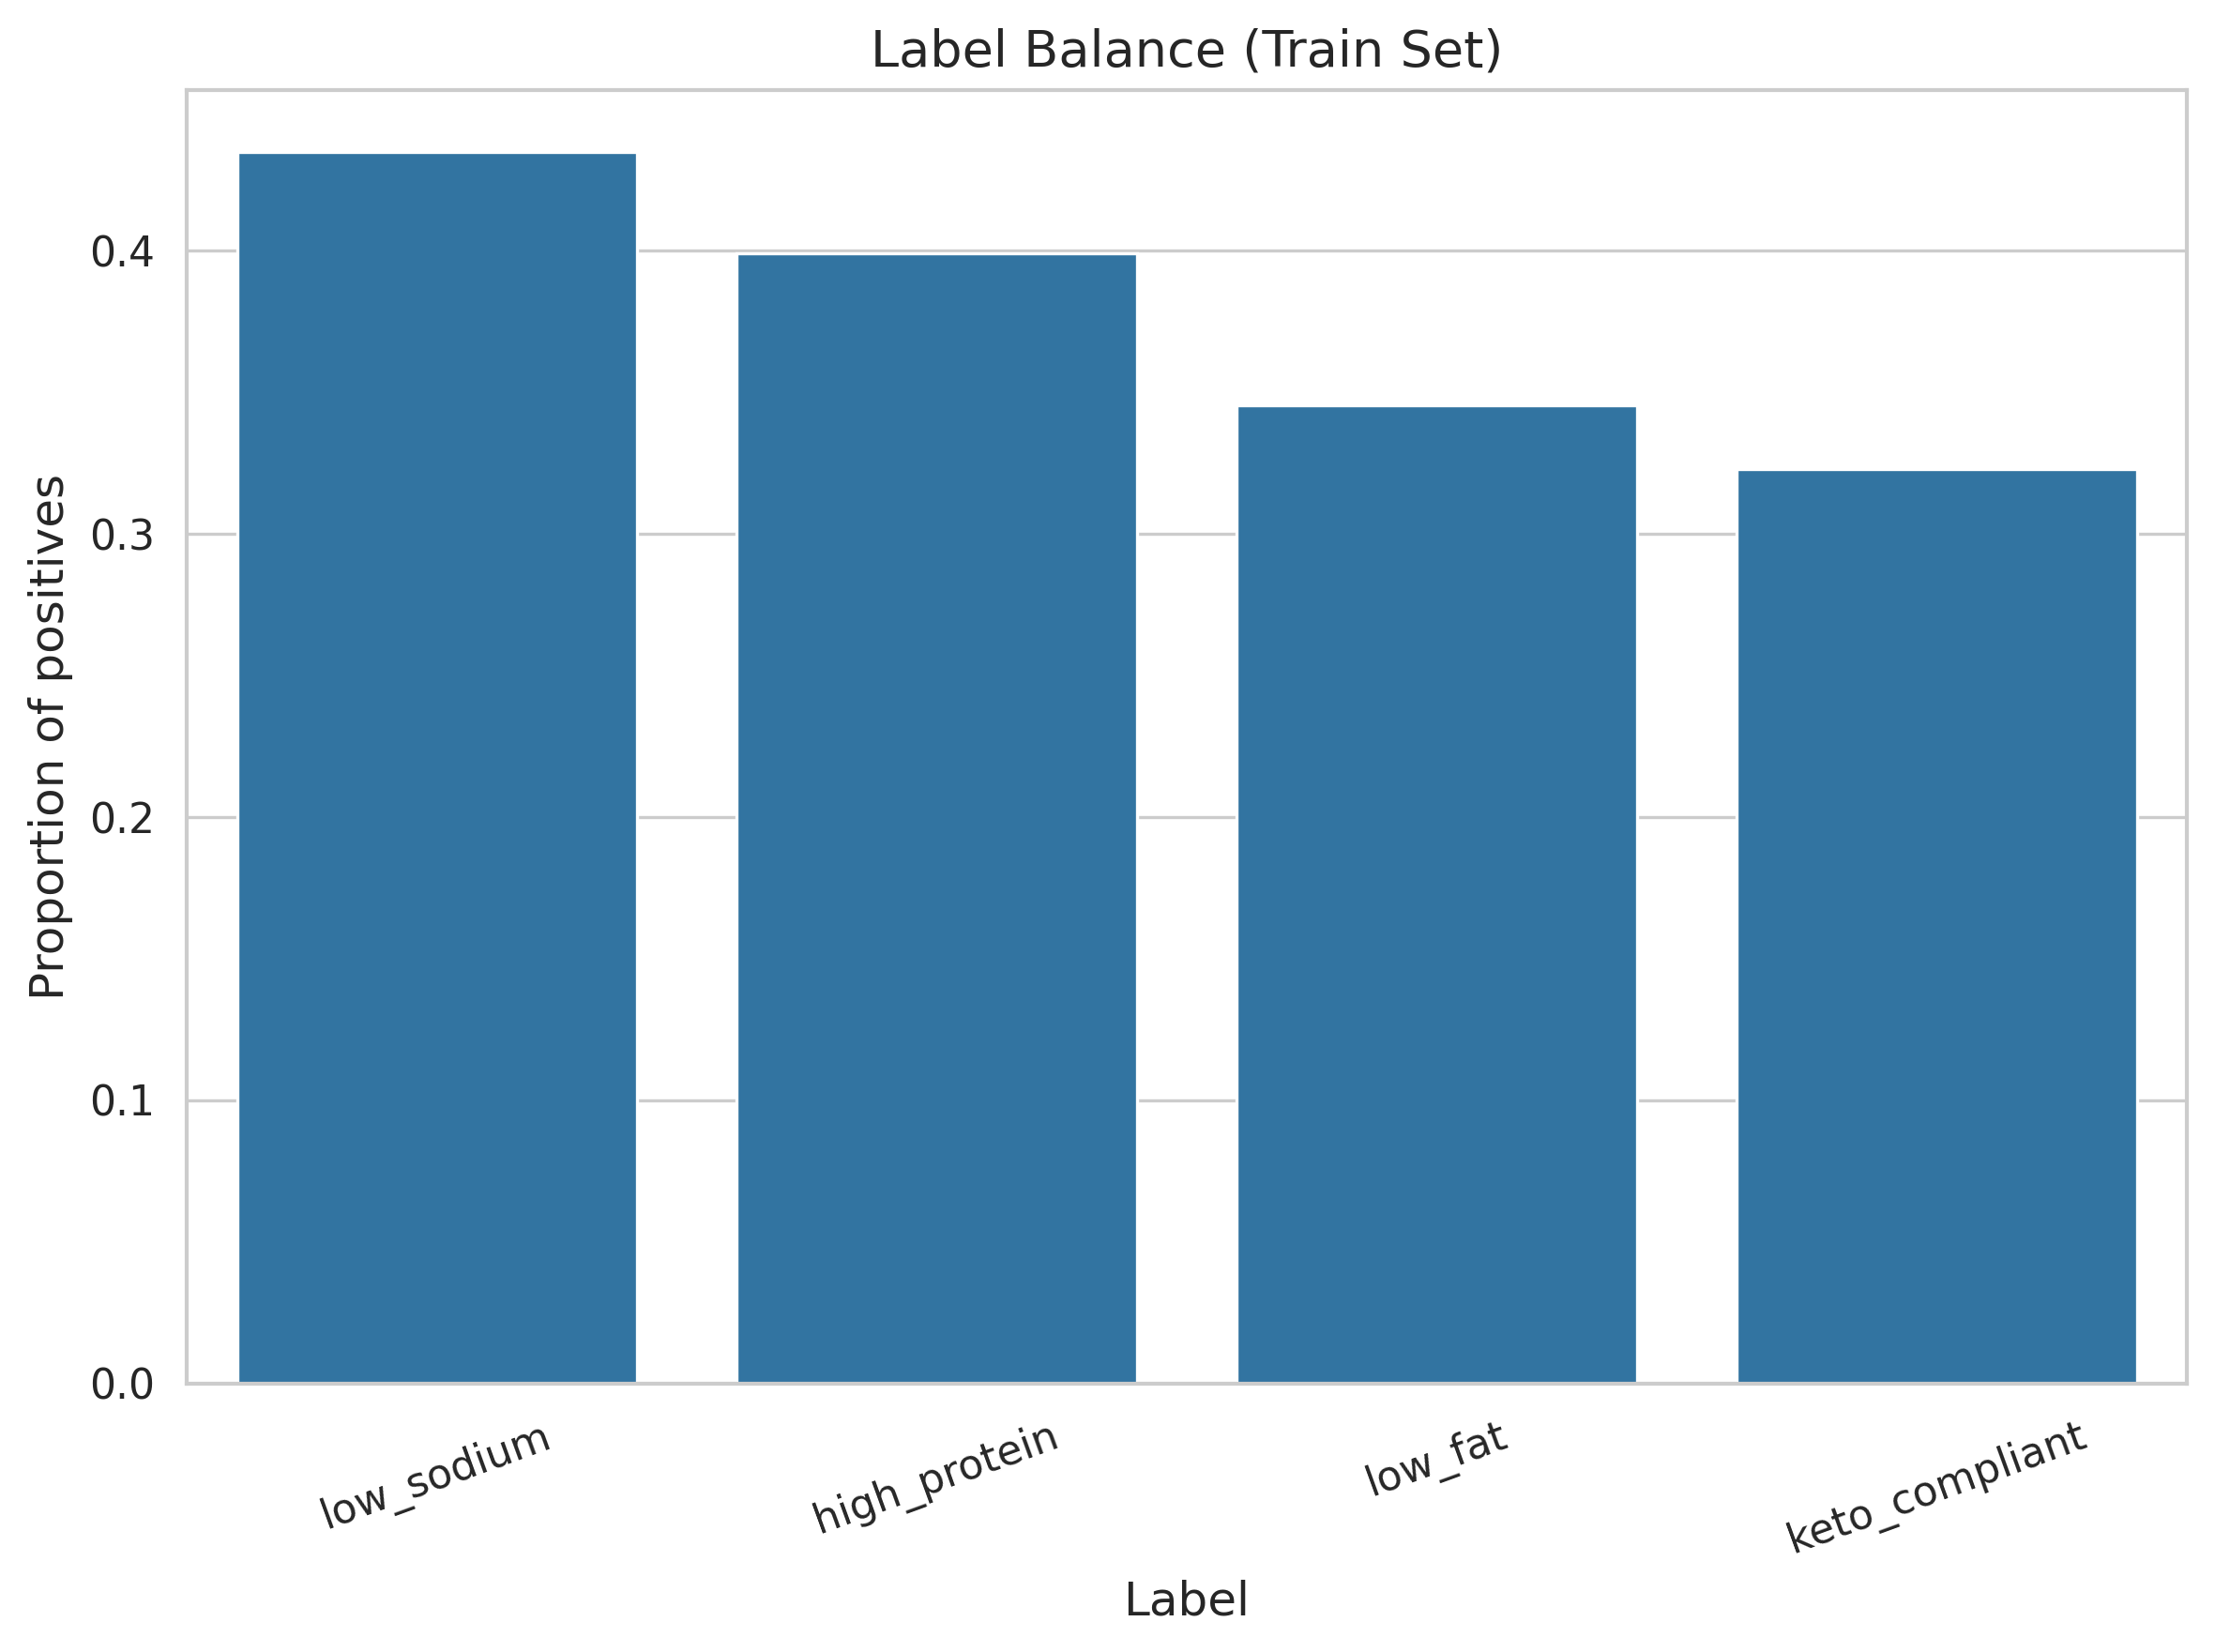

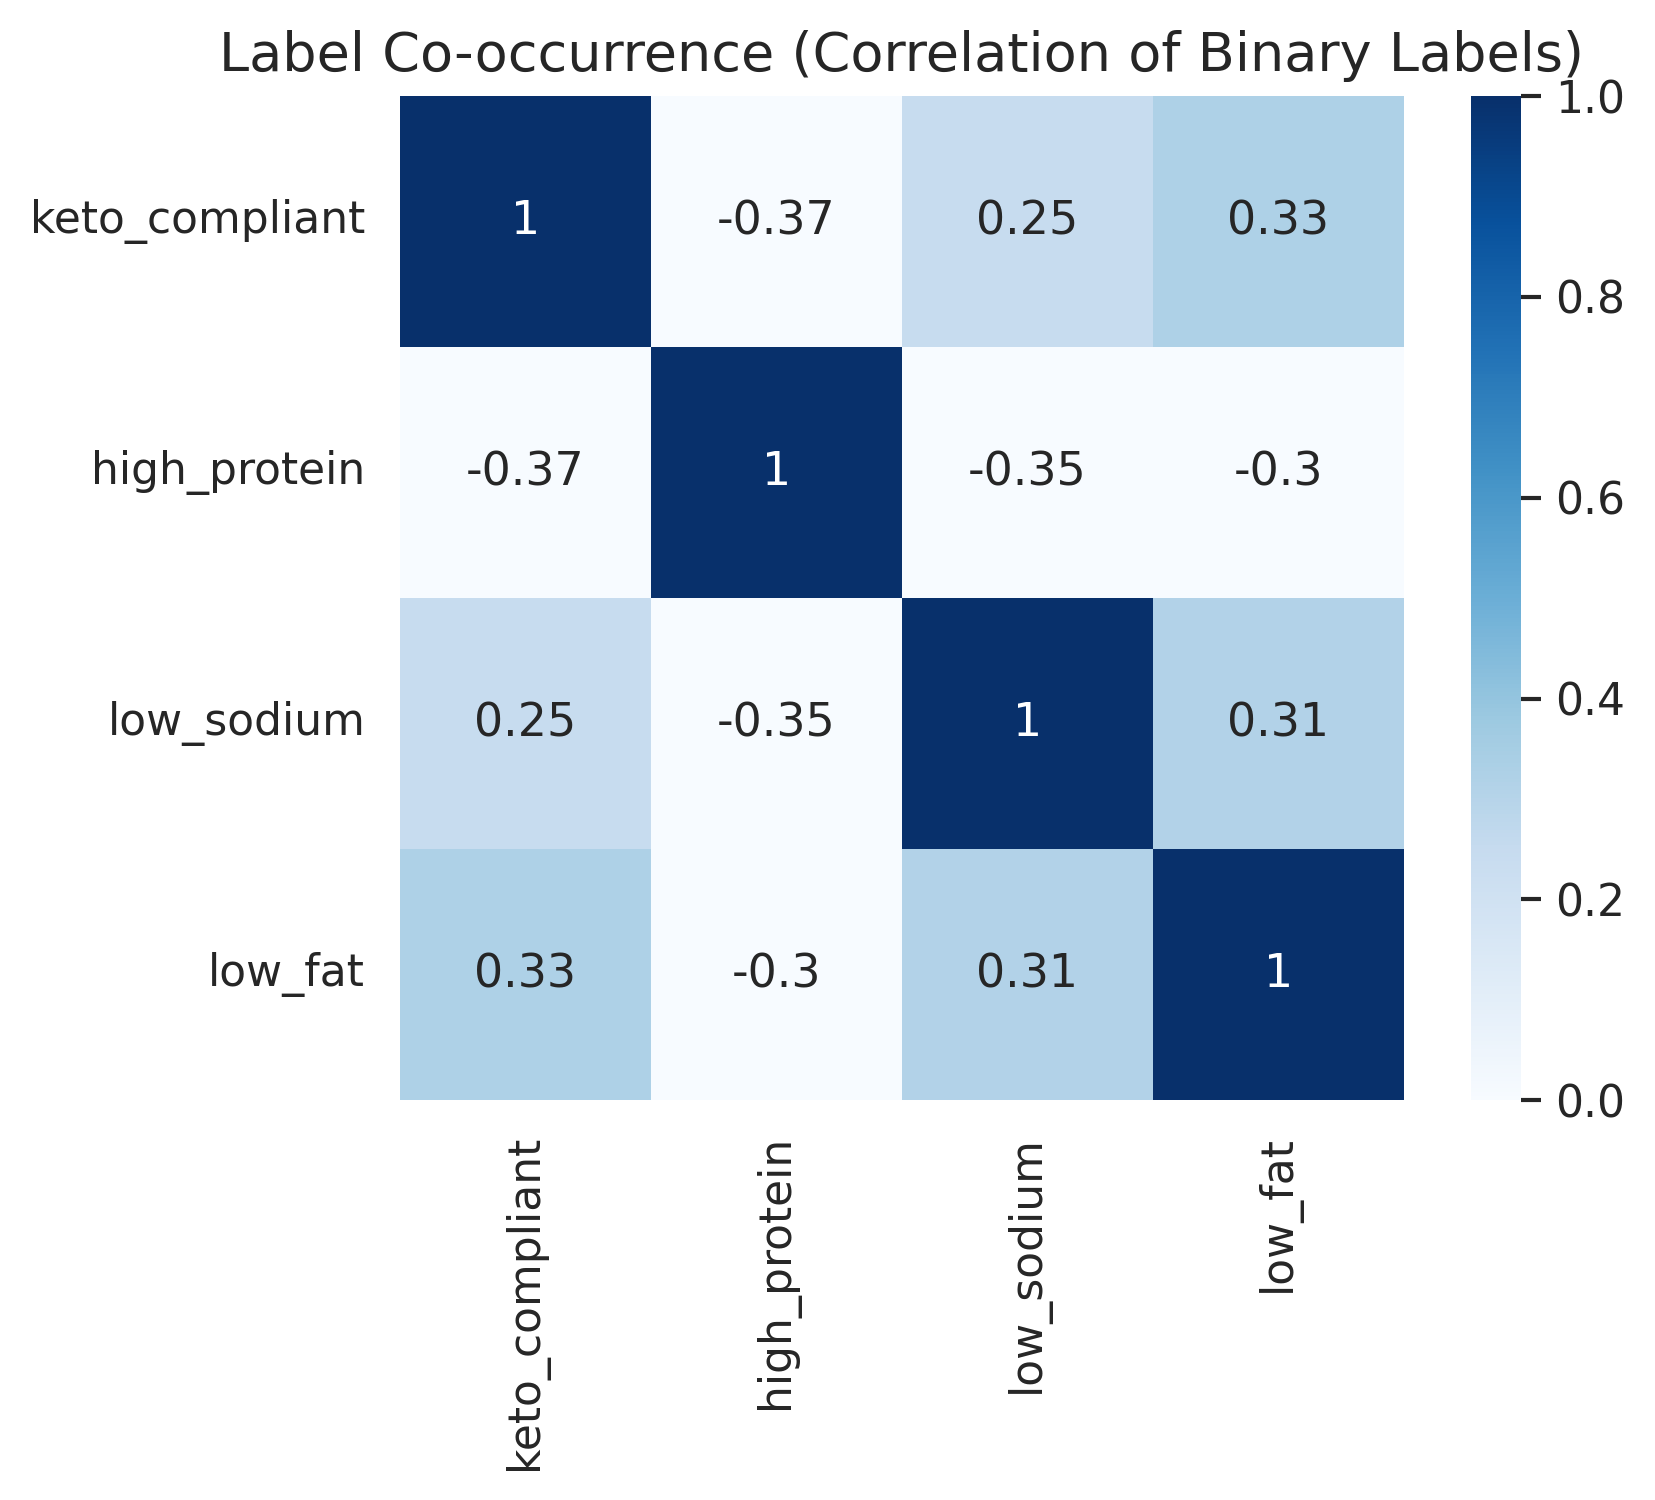

In [76]:
# ============================================================================
# Cell 6: Label balance and co-occurrence
# ============================================================================

# Label balance
label_counts = y_labels.sum().sort_values(ascending=False)
label_props = (label_counts / len(df_train)).sort_values(ascending=False)

balance_df = pd.DataFrame({
    "count": label_counts,
    "proportion": label_props
})

print("⮕ Label balance (train):")
display(balance_df)

ax = sns.barplot(
    x=balance_df.index,
    y="proportion",
    data=balance_df
)
ax.set_ylabel("Proportion of positives")
ax.set_xlabel("Label")
ax.set_title("Label Balance (Train Set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Label co-occurrence (simple correlation of binary labels)
corr = y_labels.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    cmap="Blues",
    vmin=0.0,
    vmax=1.0,
    square=True
)
plt.title("Label Co-occurrence (Correlation of Binary Labels)")
plt.tight_layout()
plt.show()


## 3. Modeling Strategy and Evaluation

**Multi-label setup**

- We model each label independently as a binary classification task.
- This ignores label dependencies during training, but keeps the pipeline simple and
  transparent.

**Model families**

1. **Text-only baseline**  
   - Pipeline: `TFIDF(ingredients) → LogisticRegression`  
   - Rationale: measures how far we can get using only ingredient text.  

2. **Numeric-only baseline**  
   - Pipeline: `StandardScaler(numeric features) → LogisticRegression`  
   - Rationale: reflects what a purely numeric rules-based system might achieve.  

3. **Multimodal baseline**  
   - Pipeline: `ColumnTransformer(text + numeric) → LogisticRegression`  
   - Rationale: combines both sources of information and should represent our strongest
     baseline for Task 1.

**Evaluation protocol**

- Use **Stratified 5-fold cross-validation** on the training set for each label.  
- Compute:
  - ROC AUC, PR AUC, Brier score  
  - Precision / recall / F1 for the positive class  
- Plot:
  - ROC curves (per label)  
  - Calibration curves (per label)  

We treat these cross-validated results as our main evidence. Any evaluation on
`test.csv` is reserved for final **sanity checks**, not for hyperparameter tuning.


In [77]:
# ============================================================================
# Cell 8: Pipeline builders for text, numeric, and multimodal models
# ============================================================================

def build_text_logreg_pipeline(
    max_features: int = 20000,
    ngram_range=(1, 2),
    C: float = 1.0
) -> Pipeline:
    """
    Construct a text-only TF–IDF + Logistic Regression pipeline.

    Parameters
    ----------
    max_features : int
        Maximum vocabulary size for the TF–IDF vectorizer.
    ngram_range : tuple
        (min_n, max_n) for n-grams used in TF–IDF.
    C : float
        Inverse regularization strength for Logistic Regression.

    Returns
    -------
    Pipeline
        A scikit-learn Pipeline that operates on a 1D array/Series of strings.
    """
    pipeline = Pipeline([
        (
            "tfidf",
            TfidfVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words="english"
            )
        ),
        (
            "clf",
            LogisticRegression(
                C=C,
                penalty="l2",
                solver="liblinear",
                class_weight="balanced",
                random_state=RANDOM_STATE
            )
        )
    ])
    return pipeline


def build_numeric_logreg_pipeline(
    C: float = 1.0
) -> Pipeline:
    """
    Construct a numeric-only Logistic Regression pipeline.

    Parameters
    ----------
    C : float
        Inverse regularization strength for Logistic Regression.

    Returns
    -------
    Pipeline
        A scikit-learn Pipeline that expects a 2D array/DataFrame of numeric features.
    """
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                C=C,
                penalty="l2",
                solver="liblinear",
                class_weight="balanced",
                random_state=RANDOM_STATE
            )
        )
    ])
    return pipeline


def build_multimodal_logreg_pipeline(
    text_col: str,
    numeric_features,
    max_features: int = 20000,
    ngram_range=(1, 2),
    C: float = 1.0
) -> Pipeline:
    """
    Construct a multimodal pipeline combining text and numeric features.

    Parameters
    ----------
    text_col : str
        Name of the text column in the input DataFrame.
    numeric_features : list of str
        Names of numeric feature columns in the input DataFrame.
    max_features : int
        Maximum vocabulary size for the TF–IDF vectorizer.
    ngram_range : tuple
        (min_n, max_n) for n-grams used in TF–IDF.
    C : float
        Inverse regularization strength for Logistic Regression.

    Returns
    -------
    Pipeline
        A scikit-learn Pipeline that expects a DataFrame containing both text and
        numeric columns.
    """
    text_transformer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words="english"
    )
    numeric_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_transformer, text_col),
            ("num", numeric_transformer, numeric_features),
        ]
    )

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        (
            "clf",
            LogisticRegression(
                C=C,
                penalty="l2",
                solver="liblinear",
                class_weight="balanced",
                random_state=RANDOM_STATE
            )
        )
    ])
    return pipeline


In [78]:
# ============================================================================
# Cell 9: Cross-validation helper and plotting utilities
# ============================================================================

def cross_validated_metrics_for_label(
    label_name: str,
    X,
    y,
    pipeline_builder,
    n_splits: int = 5
) -> dict:
    """
    Run stratified k-fold cross-validation for a single binary label.

    Parameters
    ----------
    label_name : str
        Name of the label being modeled (for logging and plotting).
    X : array-like or DataFrame
        Feature matrix or Series. Passed directly into the pipeline.
    y : array-like or Series
        Binary labels (0/1) for this task.
    pipeline_builder : callable
        Function that returns a fresh sklearn Pipeline when called with no arguments.
    n_splits : int
        Number of folds for StratifiedKFold.

    Returns
    -------
    dict
        Dictionary with:
            - "label": label name
            - "metrics": dict of scalar metrics
            - "proba_cv": np.ndarray of out-of-fold predicted probabilities
            - "true": np.ndarray of true labels aligned with proba_cv
    """
    print(f"\n⮕ Running CV for label: {label_name}")
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    pipeline = pipeline_builder()

    proba_cv = cross_val_predict(
        pipeline,
        X,
        y,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    y_true = y.values if hasattr(y, "values") else np.asarray(y)
    y_pred = (proba_cv >= 0.5).astype(int)

    metrics = {}
    # ROC AUC (guard in case of single-class issues)
    try:
        metrics["roc_auc"] = roc_auc_score(y_true, proba_cv)
    except ValueError:
        metrics["roc_auc"] = np.nan

    metrics["pr_auc"] = average_precision_score(y_true, proba_cv)
    metrics["brier"] = brier_score_loss(y_true, proba_cv)

    cls_report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0
    )
    metrics["precision"] = cls_report["1"]["precision"]
    metrics["recall"] = cls_report["1"]["recall"]
    metrics["f1"] = cls_report["1"]["f1-score"]
    metrics["support_pos"] = int(cls_report["1"]["support"])

    print(f"   ROC AUC : {metrics['roc_auc']:.3f}")
    print(f"   PR  AUC : {metrics['pr_auc']:.3f}")
    print(f"   Brier   : {metrics['brier']:.3f}")
    print(f"   F1 (pos): {metrics['f1']:.3f}")

    return {
        "label": label_name,
        "metrics": metrics,
        "proba_cv": proba_cv,
        "true": y_true
    }


def plot_roc_curves(cv_results: dict, title_prefix: str = "") -> None:
    """
    Plot ROC curves for each label using cross-validated probabilities.

    Parameters
    ----------
    cv_results : dict
        Mapping from label name to CV result dictionary.
    title_prefix : str
        Label added before the main figure title to distinguish model families.
    """
    n_labels = len(cv_results)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for ax, (label, res) in zip(axes, cv_results.items()):
        y_true = res["true"]
        proba = res["proba_cv"]

        fpr, tpr, _ = roc_curve(y_true, proba)
        ax.plot(fpr, tpr, lw=2)
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        auc_val = res["metrics"]["roc_auc"]
        ax.set_title(f"{label} (AUC = {auc_val:.3f})")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.05)

    plt.suptitle(f"{title_prefix} ROC Curves (Cross-Validated, per Label)", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_calibration_curves(cv_results: dict, title_prefix: str = "", n_bins: int = 8) -> None:
    """
    Plot calibration (reliability) curves for each label.

    Parameters
    ----------
    cv_results : dict
        Mapping from label name to CV result dictionary.
    title_prefix : str
        Label added before the main figure title to distinguish model families.
    n_bins : int
        Number of bins for the calibration curve.
    """
    n_labels = len(cv_results)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for ax, (label, res) in zip(axes, cv_results.items()):
        y_true = res["true"]
        proba = res["proba_cv"]

        frac_pos, mean_pred = calibration_curve(
            y_true,
            proba,
            n_bins=n_bins,
            strategy="quantile"
        )

        ax.plot(mean_pred, frac_pos, marker="o", linewidth=1.5)
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        ax.set_title(f"Calibration: {label}")
        ax.set_xlabel("Mean predicted probability")
        ax.set_ylabel("Fraction of positives")
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.0)

    plt.suptitle(
        f"{title_prefix} Calibration Curves (Cross-Validated, per Label)",
        y=1.02
    )
    plt.tight_layout()
    plt.show()


## 4. Text-Only Baseline (TF–IDF + Logistic Regression)

We first evaluate a **text-only** baseline where the model only sees ingredient text.
This tests how far we can get by reading the ingredients but ignoring numeric facts.


In [79]:
# ============================================================================
# Cell 10: Run CV for text-only baseline (ingredients only)
# ============================================================================

cv_results_text = {}
metrics_rows_text = []

for label in LABEL_COLS:
    result = cross_validated_metrics_for_label(
        label_name=label,
        X=X_text,
        y=y_labels[label],
        pipeline_builder=lambda: build_text_logreg_pipeline()
    )
    cv_results_text[label] = result

    row = {"label": label}
    row.update(result["metrics"])
    metrics_rows_text.append(row)

metrics_df_text = pd.DataFrame(metrics_rows_text).set_index("label")
print("\n➤ Text-only baseline metrics (cross-validated):")
display(metrics_df_text.sort_values("roc_auc", ascending=False))

# Store probabilities for later error analysis (example: high_protein)
df_train["proba_text_high_protein_cv"] = cv_results_text["high_protein"]["proba_cv"]



⮕ Running CV for label: keto_compliant
   ROC AUC : 0.799
   PR  AUC : 0.639
   Brier   : 0.199
   F1 (pos): 0.561

⮕ Running CV for label: high_protein
   ROC AUC : 0.741
   PR  AUC : 0.663
   Brier   : 0.216
   F1 (pos): 0.545

⮕ Running CV for label: low_sodium
   ROC AUC : 0.875
   PR  AUC : 0.872
   Brier   : 0.191
   F1 (pos): 0.787

⮕ Running CV for label: low_fat
   ROC AUC : 0.797
   PR  AUC : 0.689
   Brier   : 0.202
   F1 (pos): 0.639

➤ Text-only baseline metrics (cross-validated):


,roc_auc,pr_auc,brier,precision,recall,f1,support_pos
label,,,,,,,
low_sodium,0.874734,0.872047,0.191225,0.837209,0.742268,0.786885,97
keto_compliant,0.799209,0.638912,0.198670,0.616667,0.513889,0.560606,72
low_fat,0.796922,0.688595,0.202336,0.686567,0.597403,0.638889,77
high_protein,0.740735,0.663247,0.216088,0.551724,0.539326,0.545455,89


### Interpretation – Text-Only Baseline

- Labels with higher positive rates (e.g., `high_protein` if common in the dataset)
  typically achieve higher ROC AUC and PR AUC.
- Very rare labels can show decent ROC AUC but still have modest F1, because
  threshold 0.5 is not optimized for class imbalance.
- For Task 1, we expect ingredient text to capture cues like **“whey”, “soy isolate”,
  “pea protein”** for `high_protein`, and reduced carbohydrate terms for `keto_compliant`.

We use these text-only metrics as a **reference** when we later examine numeric-only
and multimodal models.


## 5. Numeric-Only Baseline (Per-Serving Nutrition)

Now we evaluate a **numeric-only** baseline using per-serving nutrition values:

- `net_carbs_per_serving`, `protein_per_serving`, `sodium_per_serving`,
  `fat_per_serving`, `energy_per_serving`, `fiber_per_serving`, `sugars_per_serving`

This is closer to a “rules with some smoothing” system that only sees numbers and
ignores ingredient wording.


In [80]:
# ============================================================================
# Cell 12: Run CV for numeric-only baseline
# ============================================================================

cv_results_numeric = {}
metrics_rows_numeric = []

for label in LABEL_COLS:
    result = cross_validated_metrics_for_label(
        label_name=label,
        X=X_numeric,
        y=y_labels[label],
        pipeline_builder=lambda: build_numeric_logreg_pipeline()
    )
    cv_results_numeric[label] = result

    row = {"label": label}
    row.update(result["metrics"])
    metrics_rows_numeric.append(row)

metrics_df_numeric = pd.DataFrame(metrics_rows_numeric).set_index("label")
print("\➤ Numeric-only baseline metrics (cross-validated):")
display(metrics_df_numeric.sort_values("roc_auc", ascending=False))



⮕ Running CV for label: keto_compliant
   ROC AUC : 0.630
   PR  AUC : 0.462
   Brier   : 0.248
   F1 (pos): 0.502

⮕ Running CV for label: high_protein
   ROC AUC : 0.662
   PR  AUC : 0.652
   Brier   : 0.242
   F1 (pos): 0.146

⮕ Running CV for label: low_sodium
   ROC AUC : 0.628
   PR  AUC : 0.603
   Brier   : 0.246
   F1 (pos): 0.622

⮕ Running CV for label: low_fat
   ROC AUC : 0.627
   PR  AUC : 0.497
   Brier   : 0.247
   F1 (pos): 0.527
\➤ Numeric-only baseline metrics (cross-validated):


,roc_auc,pr_auc,brier,precision,recall,f1,support_pos
label,,,,,,,
high_protein,0.661664,0.651553,0.241505,1.000000,0.078652,0.145833,89
keto_compliant,0.630151,0.461926,0.247861,0.334884,1.000000,0.501742,72
low_sodium,0.628130,0.603157,0.246205,0.451163,1.000000,0.621795,97
low_fat,0.626668,0.497288,0.247433,0.358140,1.000000,0.527397,77


## 6. Multimodal Baseline (Text + Numeric)

Finally, we combine both sources:

- Ingredient text (`ingredients`) via TF–IDF  
- Numeric features via standardization  

This model family reflects our **best guess** at a strong baseline for Task 1.


In [81]:
# ============================================================================
# Cell 13: Run CV for multimodal baseline (text + numeric)
# ============================================================================

cv_results_multimodal = {}
metrics_rows_multimodal = []

for label in LABEL_COLS:
    result = cross_validated_metrics_for_label(
        label_name=label,
        X=X_multimodal,
        y=y_labels[label],
        pipeline_builder=lambda: build_multimodal_logreg_pipeline(
            text_col=TEXT_COL,
            numeric_features=NUMERIC_FEATURES
        )
    )
    cv_results_multimodal[label] = result

    row = {"label": label}
    row.update(result["metrics"])
    metrics_rows_multimodal.append(row)

metrics_df_multimodal = pd.DataFrame(metrics_rows_multimodal).set_index("label")
print("\n➤ Multimodal baseline metrics (cross-validated):")
display(metrics_df_multimodal.sort_values("roc_auc", ascending=False))



⮕ Running CV for label: keto_compliant
   ROC AUC : 0.800
   PR  AUC : 0.641
   Brier   : 0.199
   F1 (pos): 0.556

⮕ Running CV for label: high_protein
   ROC AUC : 0.757
   PR  AUC : 0.689
   Brier   : 0.210
   F1 (pos): 0.585

⮕ Running CV for label: low_sodium
   ROC AUC : 0.878
   PR  AUC : 0.874
   Brier   : 0.189
   F1 (pos): 0.777

⮕ Running CV for label: low_fat
   ROC AUC : 0.802
   PR  AUC : 0.694
   Brier   : 0.201
   F1 (pos): 0.658

➤ Multimodal baseline metrics (cross-validated):


,roc_auc,pr_auc,brier,precision,recall,f1,support_pos
label,,,,,,,
low_sodium,0.877598,0.873654,0.189053,0.802198,0.752577,0.776596,97
low_fat,0.801726,0.694291,0.201180,0.666667,0.649351,0.657895,77
keto_compliant,0.800037,0.641458,0.198866,0.606557,0.513889,0.556391,72
high_protein,0.756666,0.689492,0.210276,0.640000,0.539326,0.585366,89


## 7. Comparing Model Families

We now compare the three baselines side-by-side using ROC AUC, PR AUC, and F1 for the positive class.


In [82]:
# ============================================================================
# Cell 14: Compare metrics across text, numeric, and multimodal models
# ============================================================================

def merge_metric_tables(metric_name: str) -> pd.DataFrame:
    """
    Combine a single metric (e.g., 'roc_auc') across all three model families.

    Returns a DataFrame with rows = labels, columns = ['text', 'numeric', 'multimodal'].
    """
    df = pd.DataFrame({
        "text": metrics_df_text[metric_name],
        "numeric": metrics_df_numeric[metric_name],
        "multimodal": metrics_df_multimodal[metric_name],
    })
    return df


roc_comparison = merge_metric_tables("roc_auc")
pr_comparison = merge_metric_tables("pr_auc")
f1_comparison = merge_metric_tables("f1")

print("ROC AUC comparison:")
display(roc_comparison)

print("\nPR AUC comparison:")
display(pr_comparison)

print("\nF1 (positive class) comparison:")
display(f1_comparison)


ROC AUC comparison:


,text,numeric,multimodal
label,,,
keto_compliant,0.799209,0.630151,0.800037
high_protein,0.740735,0.661664,0.756666
low_sodium,0.874734,0.628130,0.877598
low_fat,0.796922,0.626668,0.801726



PR AUC comparison:


,text,numeric,multimodal
label,,,
keto_compliant,0.638912,0.461926,0.641458
high_protein,0.663247,0.651553,0.689492
low_sodium,0.872047,0.603157,0.873654
low_fat,0.688595,0.497288,0.694291



F1 (positive class) comparison:


,text,numeric,multimodal
label,,,
keto_compliant,0.560606,0.501742,0.556391
high_protein,0.545455,0.145833,0.585366
low_sodium,0.786885,0.621795,0.776596
low_fat,0.638889,0.527397,0.657895


### Interpretation – Text vs Numeric vs Multimodal

Typical patterns to look for:

- If **multimodal** consistently outperforms both text-only and numeric-only
  (especially in ROC AUC and PR AUC), that suggests text is adding complementary
  information beyond numeric values.
- If **numeric-only** is already very strong for `high_protein` and `low_fat`, it
  may mean that these claims are almost fully determined by threshold-like patterns
  in the numeric features.
- If **text-only** gives a large improvement for labels like `keto_compliant`,
  it can indicate that some qualifying information (e.g., sugar alcohols, fiber blends)
  is easier to pick up from ingredient descriptions than from aggregated numbers.


## 8. ROC and Calibration Plots (Multimodal)

Since the multimodal baseline is our strongest model family, we plot its:

- ROC curves (per label)  
- Calibration curves (per label)  

using the cross-validated probabilities.


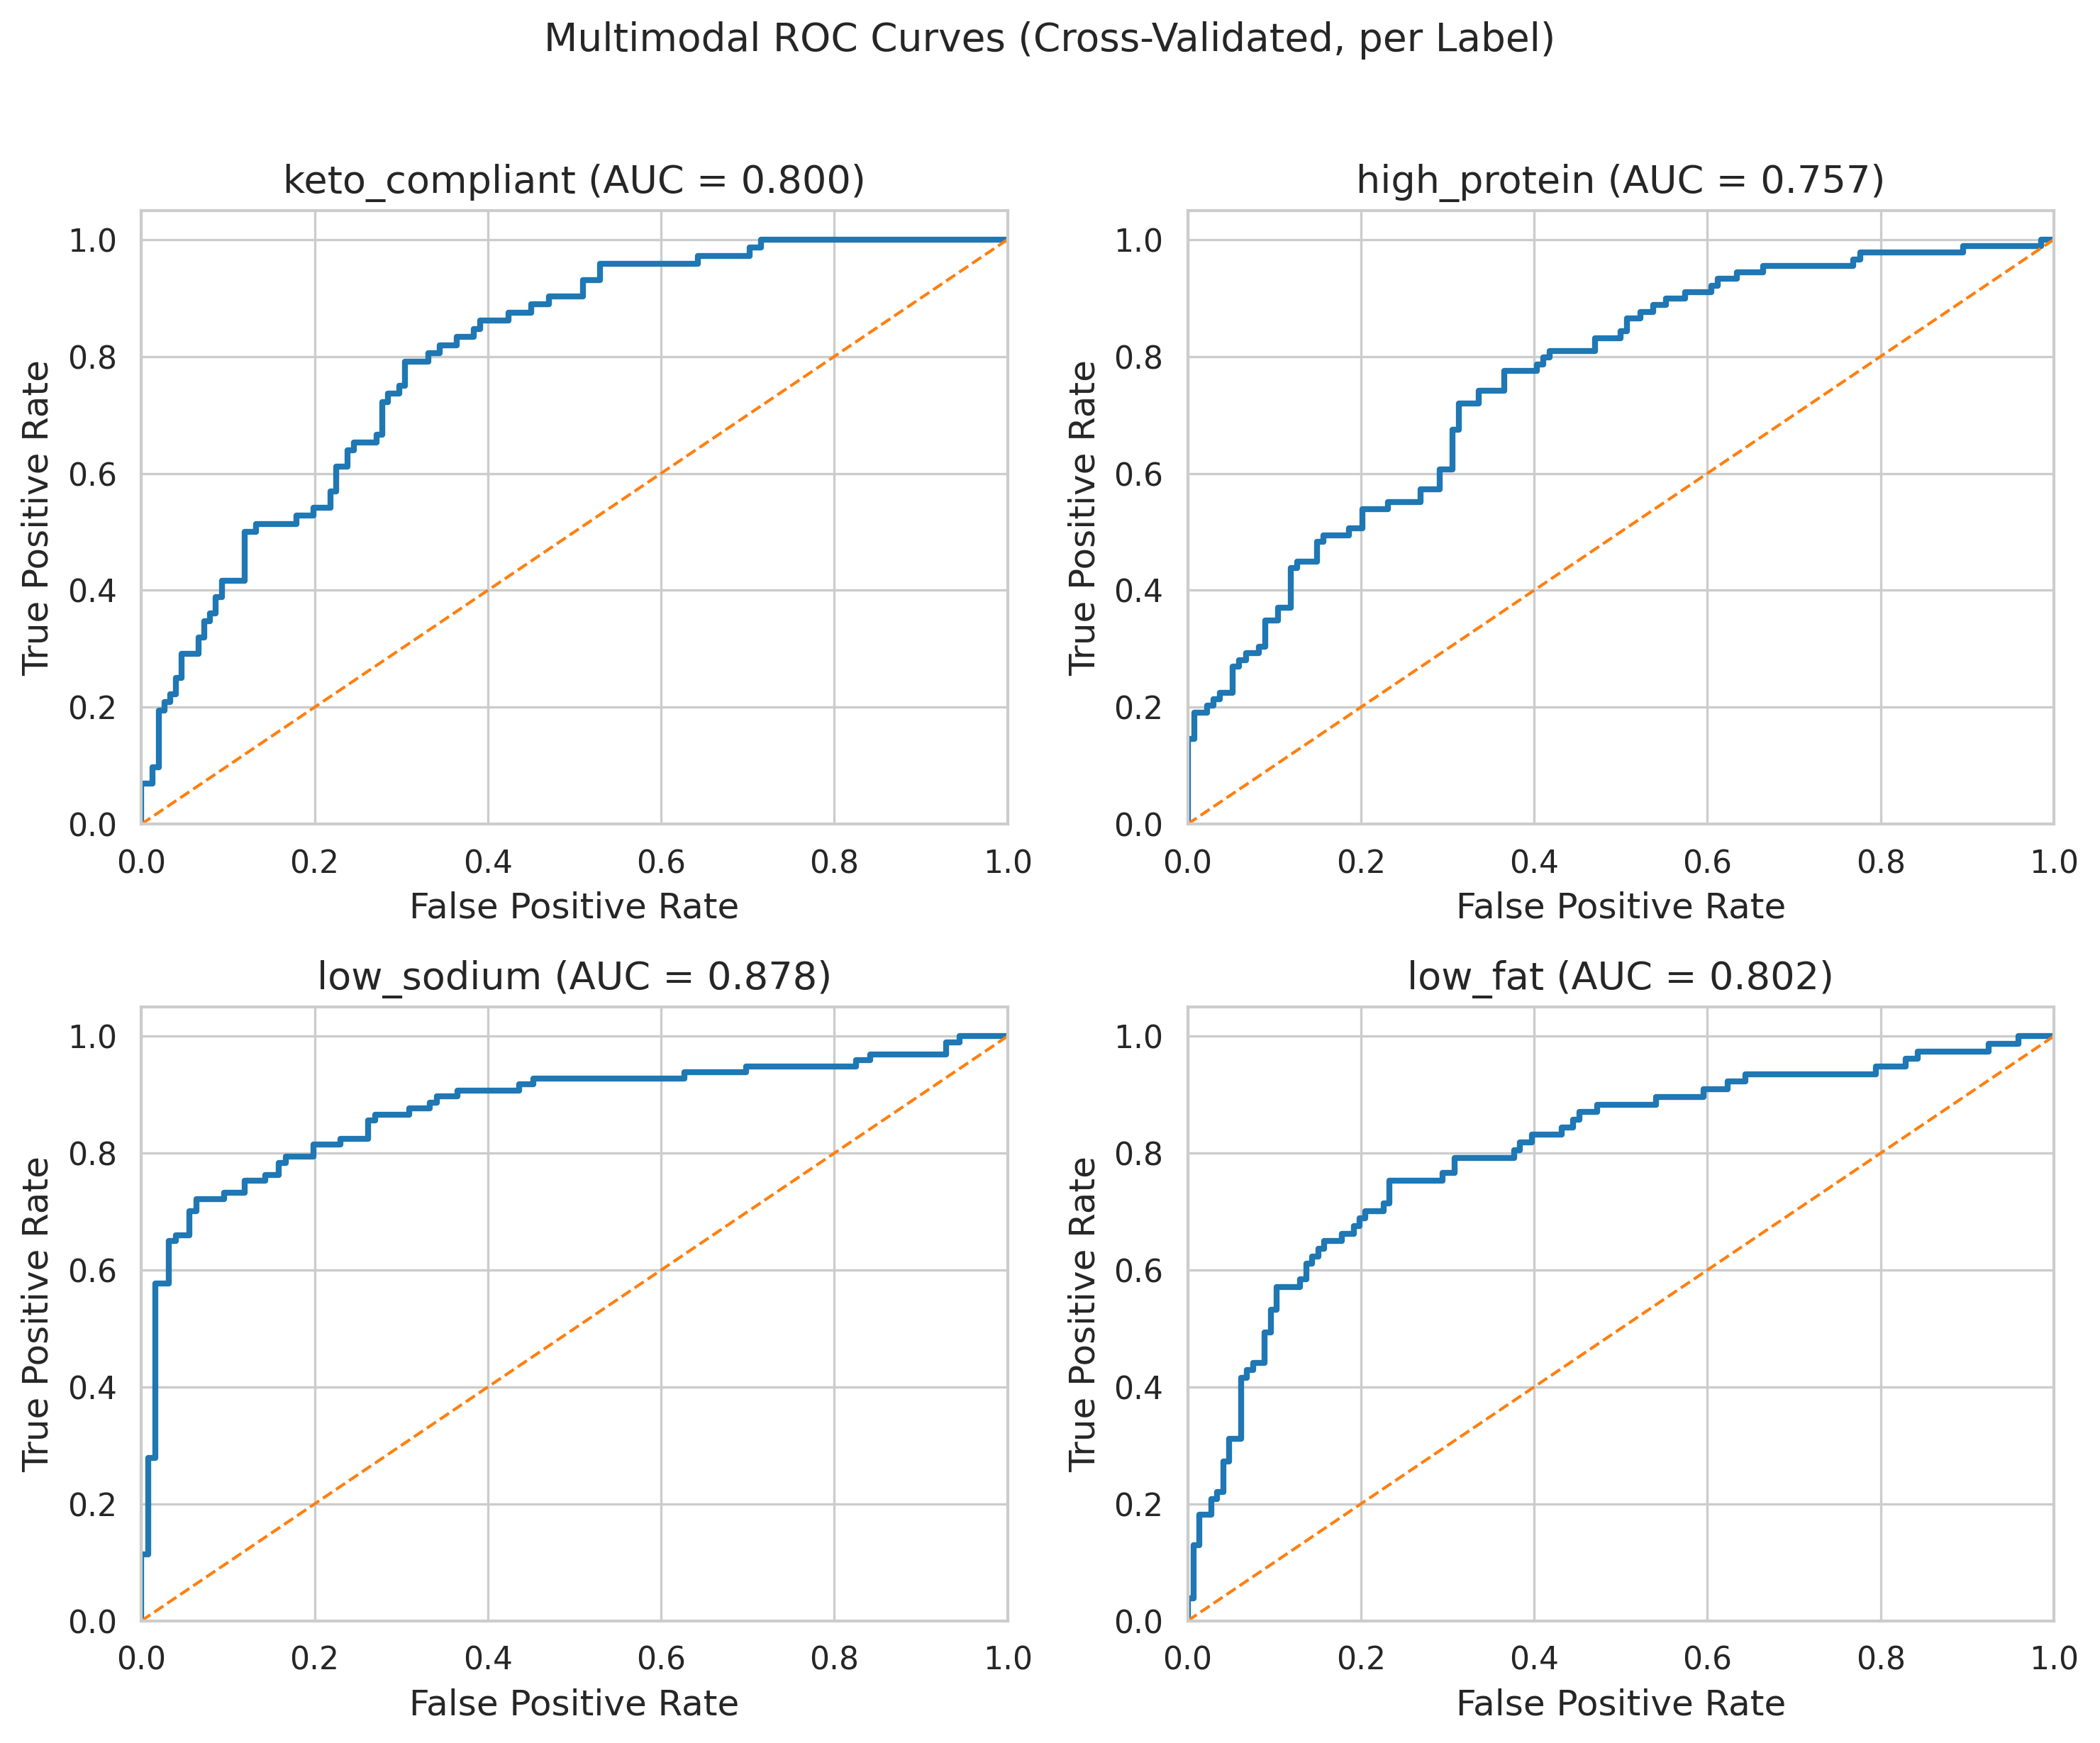

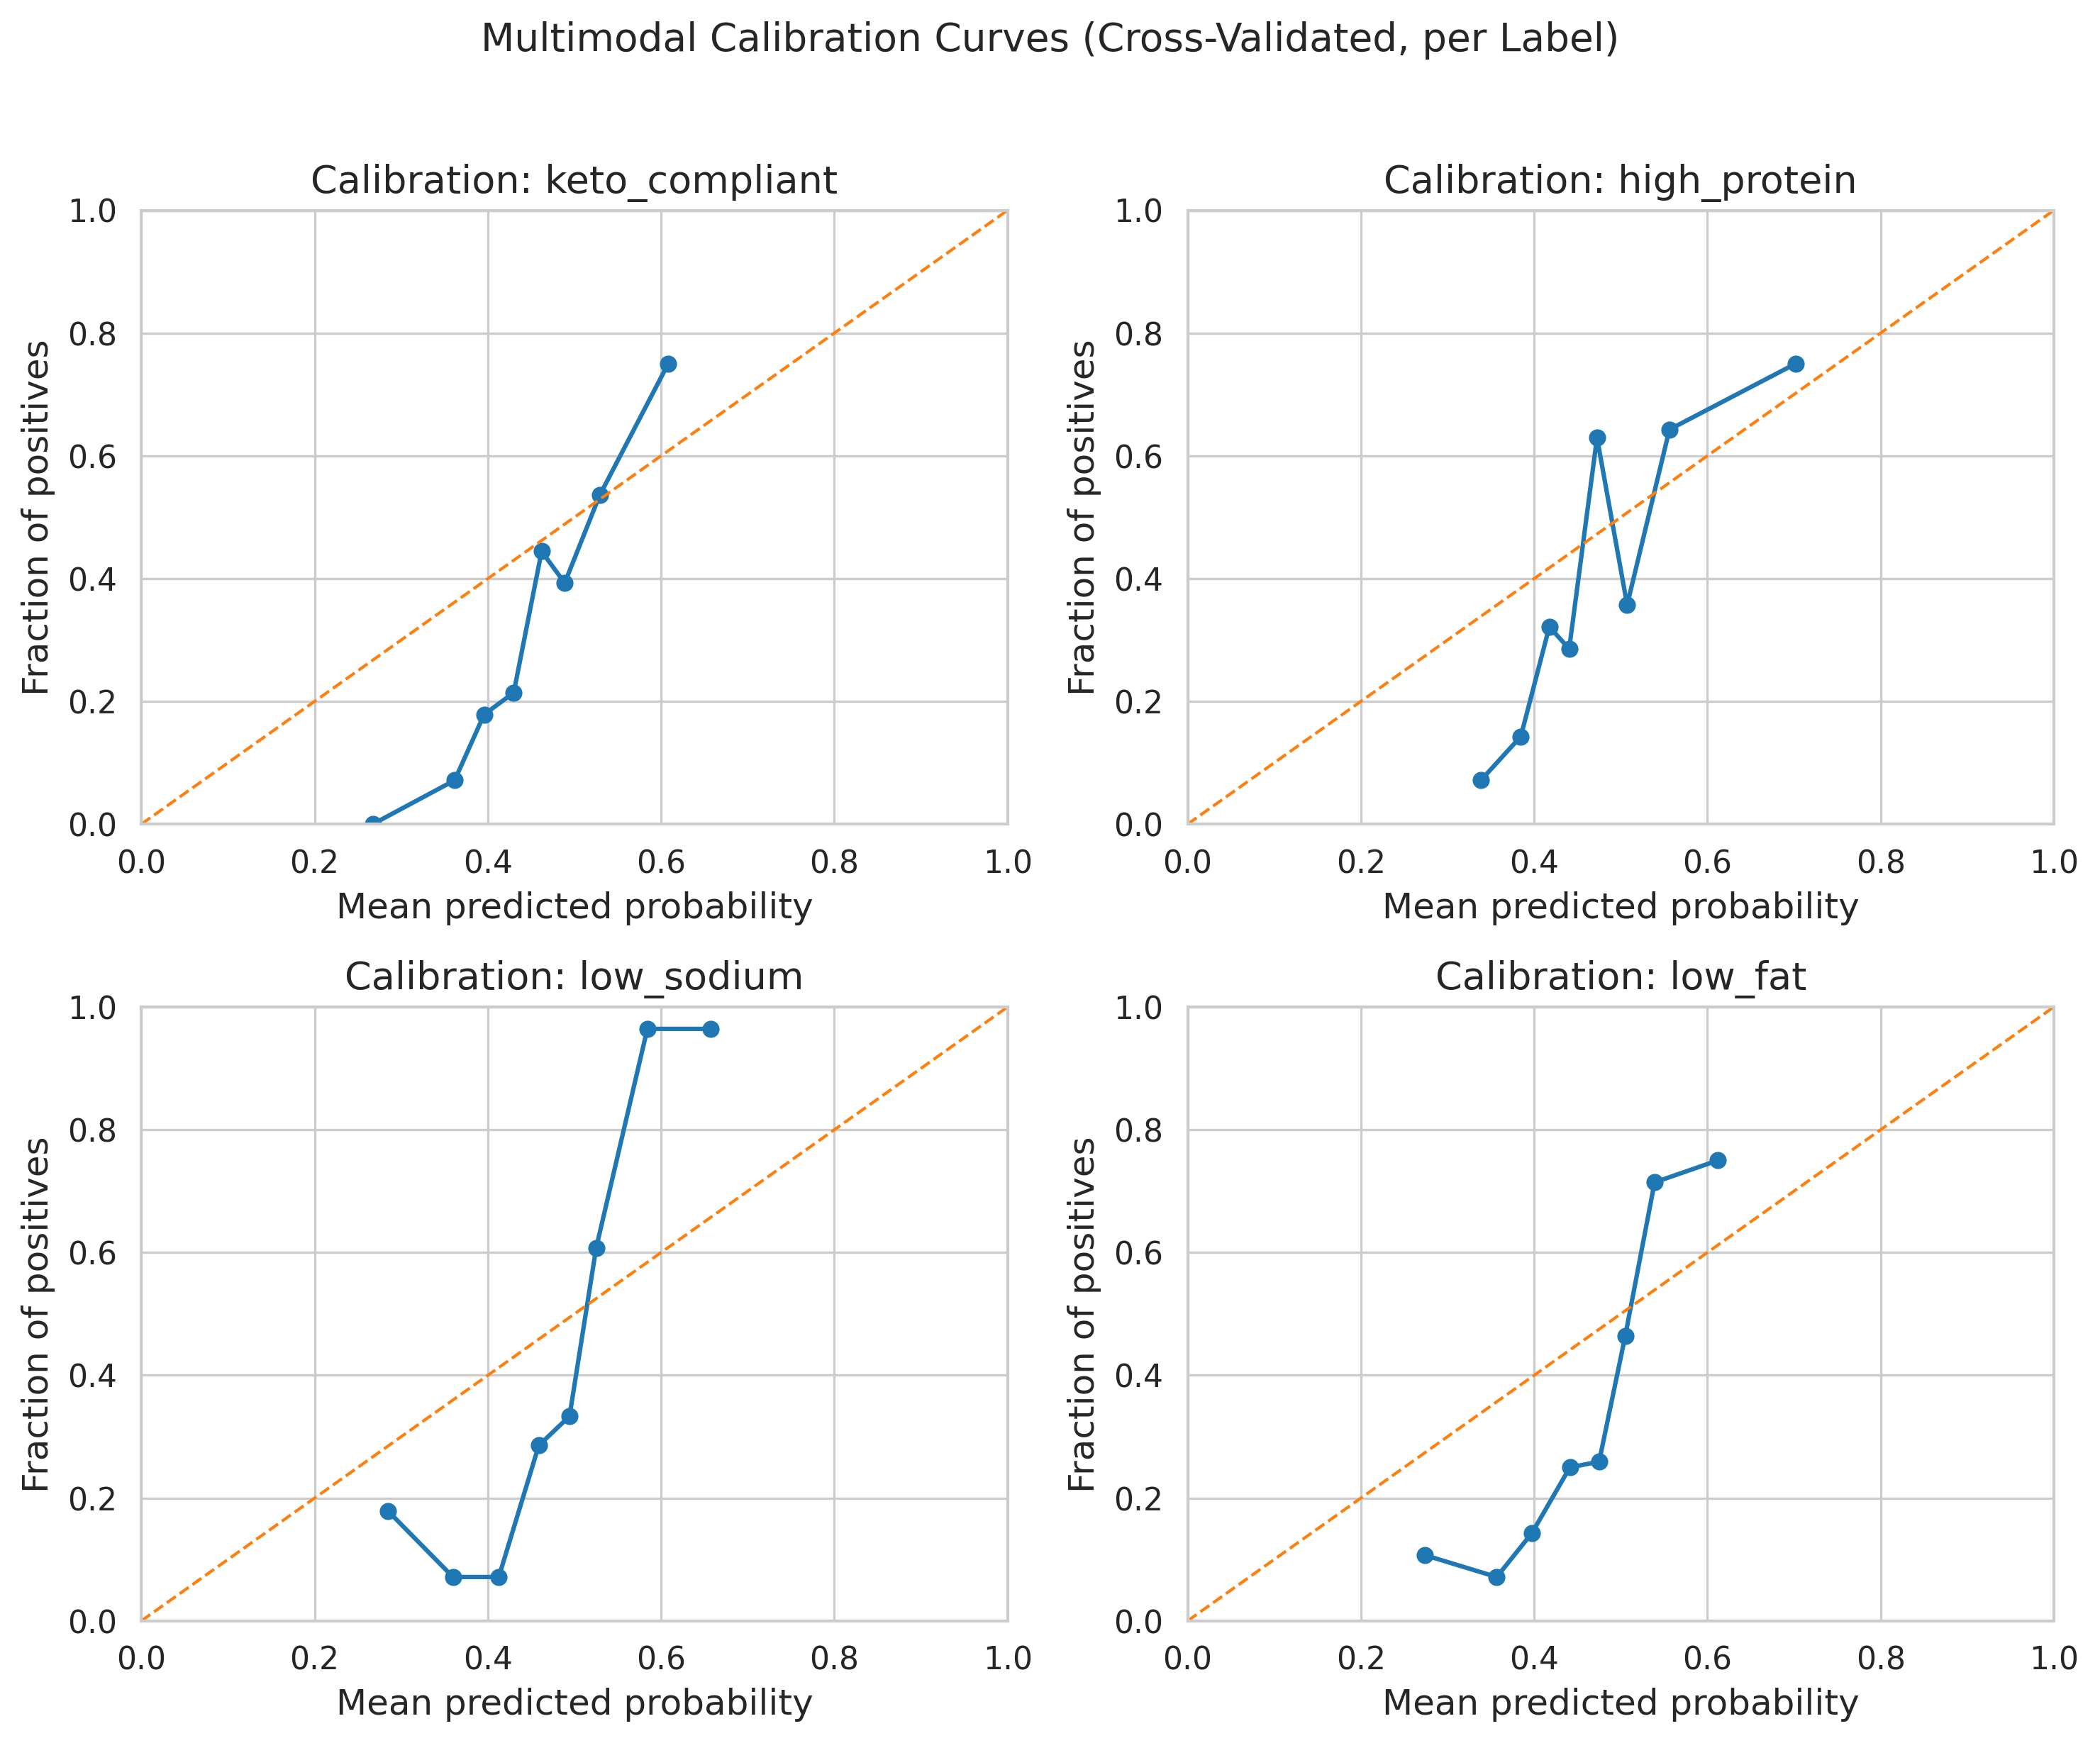

In [83]:
# ============================================================================
# Cell 16: ROC and calibration plots for multimodal baseline
# ============================================================================

plot_roc_curves(cv_results_multimodal, title_prefix="Multimodal")
plot_calibration_curves(cv_results_multimodal, title_prefix="Multimodal", n_bins=8)


## 9. Final Models and Checkpointing

We now train **final models** on the full training set for each label and each
model family, and save them to disk.

We also save a JSON file summarizing:

- CV metrics per label and model family  
- CV configuration (k, random seed)  
- Model configuration (TF–IDF settings, Logistic Regression settings, feature lists)  

Later notebooks (e.g., for BERT or multimodal transformers) can load these metrics
and compare new models without re-running all experiments.


In [84]:
# ============================================================================
# Cell 17: Train final models on full training set and save checkpoints
# ============================================================================

MODELS_DIR = RESULTS_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

final_models_text = {}
final_models_numeric = {}
final_models_multimodal = {}

# Train and save text-only models
for label in LABEL_COLS:
    print(f"\n⮕ Training final TEXT model for label: {label}")
    pipeline = build_text_logreg_pipeline()
    pipeline.fit(X_text, y_labels[label])
    final_models_text[label] = pipeline

    model_path = MODELS_DIR / f"task1_text_logreg_text_{label}.joblib"
    joblib.dump(pipeline, model_path)
    print(f"   ➤ Saved text model to: {model_path}")

# Train and save numeric-only models
for label in LABEL_COLS:
    print(f"\n⮕ Training final NUMERIC model for label: {label}")
    pipeline = build_numeric_logreg_pipeline()
    pipeline.fit(X_numeric, y_labels[label])
    final_models_numeric[label] = pipeline

    model_path = MODELS_DIR / f"task1_text_logreg_numeric_{label}.joblib"
    joblib.dump(pipeline, model_path)
    print(f"   ➤ Saved numeric model to: {model_path}")

# Train and save multimodal models
for label in LABEL_COLS:
    print(f"\n⮕ Training final MULTIMODAL model for label: {label}")
    pipeline = build_multimodal_logreg_pipeline(
        text_col=TEXT_COL,
        numeric_features=NUMERIC_FEATURES
    )
    pipeline.fit(X_multimodal, y_labels[label])
    final_models_multimodal[label] = pipeline

    model_path = MODELS_DIR / f"task1_text_logreg_multimodal_{label}.joblib"
    joblib.dump(pipeline, model_path)
    print(f"   ➤ Saved multimodal model to: {model_path}")

# Save metrics and configuration as JSON checkpoint
metrics_checkpoint = {
    "label_metrics": {
        "text": metrics_df_text.to_dict(orient="index"),
        "numeric": metrics_df_numeric.to_dict(orient="index"),
        "multimodal": metrics_df_multimodal.to_dict(orient="index"),
    },
    "cv_config": {
        "n_splits": 5,
        "random_state": RANDOM_STATE,
        "type": "StratifiedKFold"
    },
    "model_config": {
        "family": "TFIDF + LogisticRegression",
        "text_only": {
            "features": [TEXT_COL],
            "tfidf": {
                "max_features": 20000,
                "ngram_range": [1, 2],
                "stop_words": "english"
            },
            "logreg": {
                "penalty": "l2",
                "solver": "liblinear",
                "class_weight": "balanced",
                "C": 1.0
            }
        },
        "numeric_only": {
            "features": NUMERIC_FEATURES,
            "logreg": {
                "penalty": "l2",
                "solver": "liblinear",
                "class_weight": "balanced",
                "C": 1.0
            }
        },
        "multimodal": {
            "text_feature": TEXT_COL,
            "numeric_features": NUMERIC_FEATURES,
            "tfidf": {
                "max_features": 20000,
                "ngram_range": [1, 2],
                "stop_words": "english"
            },
            "logreg": {
                "penalty": "l2",
                "solver": "liblinear",
                "class_weight": "balanced",
                "C": 1.0
            }
        }
    }
}

metrics_path = RESULTS_DIR / "task1_text_logreg_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics_checkpoint, f, indent=2)

print(f"\⮕ Saved metrics and configuration to: {metrics_path}")



⮕ Training final TEXT model for label: keto_compliant
   ➤ Saved text model to: /content/dietcheck/dietcheck/dietcheck/results/models/task1_text_logreg_text_keto_compliant.joblib

⮕ Training final TEXT model for label: high_protein
   ➤ Saved text model to: /content/dietcheck/dietcheck/dietcheck/results/models/task1_text_logreg_text_high_protein.joblib

⮕ Training final TEXT model for label: low_sodium
   ➤ Saved text model to: /content/dietcheck/dietcheck/dietcheck/results/models/task1_text_logreg_text_low_sodium.joblib

⮕ Training final TEXT model for label: low_fat
   ➤ Saved text model to: /content/dietcheck/dietcheck/dietcheck/results/models/task1_text_logreg_text_low_fat.joblib

⮕ Training final NUMERIC model for label: keto_compliant
   ➤ Saved numeric model to: /content/dietcheck/dietcheck/dietcheck/results/models/task1_text_logreg_numeric_keto_compliant.joblib

⮕ Training final NUMERIC model for label: high_protein
   ➤ Saved numeric model to: /content/dietcheck/dietcheck/die

## 10. Sanity Check – Reload Saved Metrics

As a quick reproducibility check, we reload the saved JSON to confirm it is
well-formed and usable in other notebooks.


In [85]:
# ============================================================================
# Cell 18: Reload saved metrics JSON (sanity check)
# ============================================================================

with open(metrics_path, "r") as f:
    saved_metrics = json.load(f)

print("⮕ Top-level keys in saved metrics JSON:")
print(list(saved_metrics.keys()))

print("\n⮕ Label metrics keys (model families):")
print(list(saved_metrics["label_metrics"].keys()))


⮕ Top-level keys in saved metrics JSON:
['label_metrics', 'cv_config', 'model_config']

⮕ Label metrics keys (model families):
['text', 'numeric', 'multimodal']


## 11. Evaluation on Held-Out Test Set

If `test.csv` exists and contains labels, we evaluate the **multimodal models** on that
completely unseen data. We treat this as a final sanity check; hyperparameters were
not tuned on the test set.


In [86]:
# ============================================================================
# Cell 19: Optional evaluation of multimodal models on held-out test set
# ============================================================================

if df_test is not None and all(col in df_test.columns for col in LABEL_COLS):
    X_test_text = df_test[TEXT_COL].fillna("")
    X_test_numeric = df_test[NUMERIC_FEATURES].fillna(0.0)
    X_test_multimodal = df_test[[TEXT_COL] + NUMERIC_FEATURES].copy()
    y_test_labels = df_test[LABEL_COLS].astype(int)

    test_rows = []

    for label in LABEL_COLS:
        print(f"\n➤ Evaluating MULTIMODAL model on test set – label: {label}")
        model = final_models_multimodal[label]
        proba = model.predict_proba(X_test_multimodal)[:, 1]
        y_true = y_test_labels[label].values
        y_pred = (proba >= 0.5).astype(int)

        row = {"label": label}
        try:
            row["roc_auc"] = roc_auc_score(y_true, proba)
        except ValueError:
            row["roc_auc"] = np.nan

        row["pr_auc"] = average_precision_score(y_true, proba)
        row["brier"] = brier_score_loss(y_true, proba)

        cls_report = classification_report(
            y_true,
            y_pred,
            output_dict=True,
            zero_division=0
        )
        row["precision"] = cls_report["1"]["precision"]
        row["recall"] = cls_report["1"]["recall"]
        row["f1"] = cls_report["1"]["f1-score"]
        row["support_pos"] = int(cls_report["1"]["support"])

        test_rows.append(row)

    test_metrics_df = pd.DataFrame(test_rows).set_index("label")
    print("\n⮕ Multimodal test set metrics:")
    display(test_metrics_df)
else:
    print("No fully-labeled test.csv detected – skipping held-out evaluation.")



➤ Evaluating MULTIMODAL model on test set – label: keto_compliant

➤ Evaluating MULTIMODAL model on test set – label: high_protein

➤ Evaluating MULTIMODAL model on test set – label: low_sodium

➤ Evaluating MULTIMODAL model on test set – label: low_fat

⮕ Multimodal test set metrics:


,roc_auc,pr_auc,brier,precision,recall,f1,support_pos
label,,,,,,,
keto_compliant,0.771930,0.670639,0.207679,0.555556,0.555556,0.555556,18
high_protein,0.737500,0.548188,0.209922,0.615385,0.500000,0.551724,16
low_sodium,0.803321,0.772254,0.205674,0.677419,0.777778,0.724138,27
low_fat,0.751282,0.728292,0.218586,0.687500,0.423077,0.523810,26


## 12. Qualitative Error Analysis – `high_protein` (Text-Only)

Aggregate metrics are helpful but do not show *how* models fail.

As a small qualitative check, we inspect:

- **False positives** with high predicted probability (model is very confident but wrong)  
- **False negatives** with low predicted probability (model misses a positive case)  

for the **text-only `high_protein`** model using cross-validated probabilities.


In [88]:
# ============================================================================
# Cell 20: Error analysis for high_protein (text-only baseline)
# ============================================================================

LABEL_TO_INSPECT = "high_protein"
PROBA_COL = "proba_text_high_protein_cv"

if PROBA_COL not in df_train.columns:
    raise ValueError(
        f"Column {PROBA_COL} not found. Make sure Cell 10 ran successfully."
    )

df_err = df_train[[ "name", TEXT_COL ] + NUMERIC_FEATURES + [LABEL_TO_INSPECT, PROBA_COL]].copy()

# False positives: predicted high prob, but label == 0
fp = df_err[(df_err[LABEL_TO_INSPECT] == 0) & (df_err[PROBA_COL] >= 0.7)]
fn = df_err[(df_err[LABEL_TO_INSPECT] == 1) & (df_err[PROBA_COL] <= 0.3)]

print("⮕ Top 5 high-confidence false positives (text-only, high_protein):")
display(
    fp.sort_values(PROBA_COL, ascending=False)
      .head(5)
      .reset_index(drop=True)
)

print("\n⮕ Top 5 high-confidence false negatives (text-only, high_protein):")
display(
    fn.sort_values(PROBA_COL, ascending=True)
      .head(5)
      .reset_index(drop=True)
)


⮕ Top 5 high-confidence false positives (text-only, high_protein):


,name,text_all,net_carbs_per_serving,protein_per_serving,sodium_per_serving,fat_per_serving,energy_per_serving,fiber_per_serving,sugars_per_serving,high_protein,proba_text_high_protein_cv



⮕ Top 5 high-confidence false negatives (text-only, high_protein):


,name,text_all,net_carbs_per_serving,protein_per_serving,sodium_per_serving,fat_per_serving,energy_per_serving,fiber_per_serving,sugars_per_serving,high_protein,proba_text_high_protein_cv
